In [83]:
import os
import torch
from torchvision.datasets import CocoDetection
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import functional as F
from pycocotools.coco import COCO
import torchvision.transforms.v2 as T

import torch
import torch.nn as nn
from torchvision.models import resnet18
from torchvision import transforms

import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

import random

In [84]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [85]:
COCO_PATH = "./data/coco/"  # change this
IMG_DIR_TRAIN = os.path.join(COCO_PATH, "images/train2017")
IMG_DIR_VAL = os.path.join(COCO_PATH, "images/val2017")
ANN_FILE_TRAIN = os.path.join(COCO_PATH, "annotations/person_keypoints_train2017.json")
ANN_FILE_VAL = os.path.join(COCO_PATH, "annotations/person_keypoints_val2017.json")

NUM_KEYPOINTS = 17
# EPOCHS = 10 
EPOCHS = 5


# Data

In [86]:
class CustomTransform:
    def __init__(self, size=(256, 256)):
        self.transform = transforms.Compose([
            transforms.Resize(size),
            transforms.ToTensor()
        ])
    
    def __call__(self, image, target):
        return self.transform(image), target
    

In [87]:
class CocoKeypointsDataset(CocoDetection):
    def __init__(self, img_folder, ann_file, transforms=None):
        super().__init__(img_folder, ann_file)
        self.coco = COCO(ann_file)
        self._transforms = transforms

    def __getitem__(self, idx):
        img, target = super().__getitem__(idx)
        orig_w, orig_h = img.size  # PIL image size (width, height)
        ann_ids = self.coco.getAnnIds(imgIds=self.ids[idx], iscrowd=None)
        anns = self.coco.loadAnns(ann_ids)
        # Filter for annotations with keypoints
        anns = [ann for ann in anns if 'keypoints' in ann]
        target = {
            "image_id": self.ids[idx],
            "annotations": anns,
            "orig_size": (orig_w, orig_h)
        }
        if self._transforms:
            img, target = self._transforms(img, target)
        return img, target
    

In [88]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    for imgs, targets in tqdm(dataloader):
        imgs = imgs.to(device)

        # Use only the first person's keypoints per image
        keypoints = torch.stack([
            t[0] if t.shape[0] > 0 else torch.zeros((17, 2), device=imgs.device)
            for t in targets
        ]).to(device)

        # Flatten keypoints to match model output shape
        keypoints = keypoints.view(keypoints.size(0), -1)

        preds = model(imgs)
        loss = criterion(preds, keypoints)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
    return total_loss / len(dataloader)


In [89]:
train_dataset = CocoKeypointsDataset(IMG_DIR_TRAIN, ANN_FILE_TRAIN, transforms=CustomTransform())
val_dataset = CocoKeypointsDataset(IMG_DIR_VAL, ANN_FILE_VAL, transforms=CustomTransform())

val_size = int(0.5 * len(val_dataset))
test_size = len(val_dataset) - val_size
val_dataset, test_dataset = random_split(val_dataset, [val_size, test_size])

loading annotations into memory...
Done (t=5.68s)
creating index...
index created!
Done (t=5.68s)
creating index...
index created!
loading annotations into memory...
loading annotations into memory...
Done (t=5.71s)
creating index...
Done (t=5.71s)
creating index...
index created!
index created!
loading annotations into memory...
loading annotations into memory...
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!
Done (t=0.24s)
creating index...
index created!
loading annotations into memory...
Done (t=0.22s)
creating index...
index created!


In [90]:
subset_len_train = int(0.05 * len(train_dataset))
subset_len_val = int(0.05 * len(val_dataset))
subset_len_test = int(0.05 * len(test_dataset))

train_dataset = torch.utils.data.Subset(train_dataset, range(subset_len_train))
val_dataset = torch.utils.data.Subset(val_dataset, range(subset_len_val))
test_dataset = torch.utils.data.Subset(test_dataset, range(subset_len_test))

In [91]:
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, collate_fn=coco_collate_fn)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, collate_fn=coco_collate_fn)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False, collate_fn=coco_collate_fn)

## Test data

In [92]:
from itertools import cycle

def visualize_prediction(img_tensor, keypoints_list, pred_keypoints_list=None):
    img = img_tensor.permute(1, 2, 0).cpu().numpy()
    plt.imshow(img)

    for kp in keypoints_list:
        kp = kp.view(-1, 2).cpu().numpy()
        plt.scatter(kp[:, 0], kp[:, 1], c='g', label='GT')

    if pred_keypoints_list is not None:
        if isinstance(pred_keypoints_list, torch.Tensor):
            pred_keypoints_list = [pred_keypoints_list]
        for pk in pred_keypoints_list:
            pk = pk.view(-1, 2).cpu().numpy()
            plt.scatter(pk[:, 0], pk[:, 1], c='r', marker='x', label='Pred')

    # Plot each set of keypoints (each human) in a different color
    colors = cycle(plt.cm.tab10.colors)
    for i, kp in enumerate(keypoints_list):
        kp = kp.view(-1, 2).cpu().numpy()
        color = next(colors)
        plt.scatter(kp[:, 0], kp[:, 1], color=color, label=f'GT {i+1}')

    plt.show()


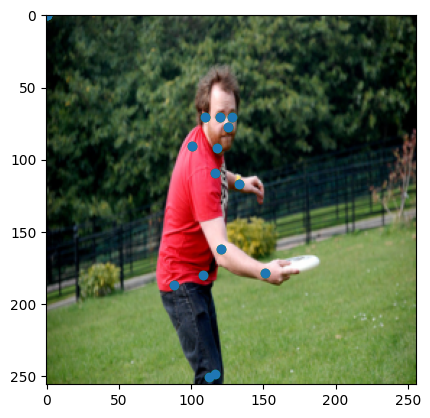

In [93]:
imgs, targets = next(iter(test_loader))
imgs = imgs.to(device)

# Pick a random index from the batch
idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
gt_kpts = targets[idx]

visualize_prediction(img, gt_kpts)

# Model

In [94]:

# class KeypointModel(nn.Module):
#     def __init__(self):
#         super().__init__()
#         self.backbone = resnet18(pretrained=True)
#         self.backbone.fc = nn.Linear(self.backbone.fc.in_features, NUM_KEYPOINTS * 2)

#     def forward(self, x):
#         return self.backbone(x)

class KeypointModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, NUM_KEYPOINTS * 2),
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


In [95]:
model = KeypointModel().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)


In [96]:
def train_one_epoch(model, dataloader, optimizer, criterion):
    model.train()
    total_loss = 0
    n_persons = 0
    for imgs, targets in tqdm(dataloader):
        imgs = imgs.to(device)
        batch_loss = 0
        for img, kps_list in zip(imgs, targets):
            for kps in kps_list:
                kps = kps.to(device)
                pred = model(img.unsqueeze(0))
                loss = criterion(pred, kps.view(1, -1))
                batch_loss += loss
                n_persons += 1
        if n_persons > 0:
            total_loss += batch_loss.item() / n_persons
        else:
            total_loss += 0
    return total_loss / len(dataloader)


In [97]:
def evaluate(model, dataloader):
    model.eval()
    preds_list, gt_list = [], []
    with torch.no_grad():
        for imgs, targets in dataloader:
            imgs = imgs.to(device)
            batch_preds = []
            batch_gts = []
            for img, kps_list in zip(imgs, targets):
                for kps in kps_list:
                    kps = kps.to(device)
                    pred = model(img.unsqueeze(0))
                    batch_preds.append(pred.cpu())
                    batch_gts.append(kps.view(1, -1).cpu())
            if batch_preds:
                preds_list.extend(batch_preds)
                gt_list.extend(batch_gts)
    return preds_list, gt_list


In [98]:
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    train_losses.append(train_loss)

    preds_list, gt_list = evaluate(model, val_loader)
    val_loss = sum(criterion(pred, gt).item() for pred, gt in zip(preds_list, gt_list)) / len(gt_list)
    val_losses.append(val_loss)

    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")


  0%|          | 0/740 [00:00<?, ?it/s]

Epoch 1/5 | Train Loss: 65.8411 | Val Loss: 5815.4149


  0%|          | 0/740 [00:00<?, ?it/s]

Epoch 2/5 | Train Loss: 54.8905 | Val Loss: 5815.4149


  0%|          | 0/740 [00:00<?, ?it/s]

Epoch 3/5 | Train Loss: 54.4811 | Val Loss: 5815.4149


  0%|          | 0/740 [00:00<?, ?it/s]

Epoch 4/5 | Train Loss: 62.9509 | Val Loss: 5815.4149


  0%|          | 0/740 [00:00<?, ?it/s]

Epoch 5/5 | Train Loss: 61.3402 | Val Loss: 5815.4149


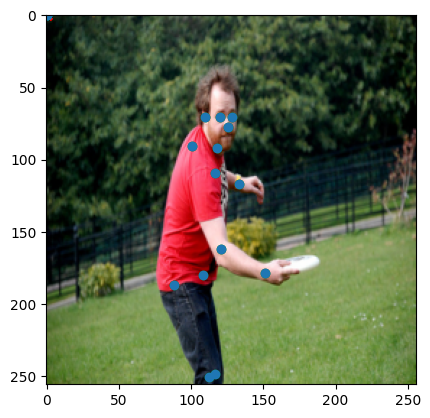

In [115]:
imgs, targets = next(iter(test_loader))
imgs = imgs.to(device)
with torch.no_grad():
    preds = model(imgs)

idx = random.randint(0, imgs.shape[0] - 1)
img = imgs[idx].cpu()
gt_kpts_list = targets[idx]  # list of N_persons x 17 x 2
pred_kpts = preds[idx].reshape(-1, 2).cpu()  # still only one pred

visualize_prediction(img, gt_kpts_list, pred_kpts)


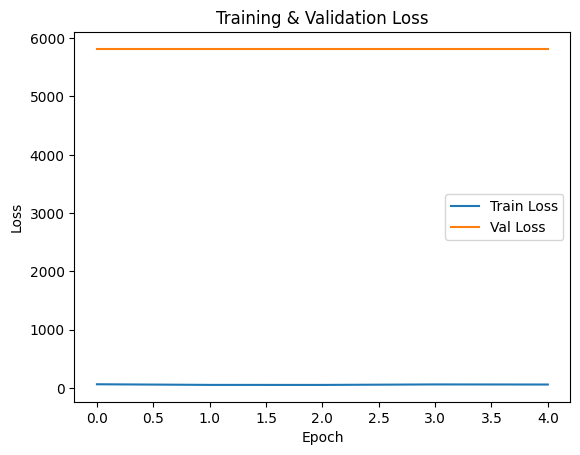

In [100]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title("Training & Validation Loss")
plt.show()
